In [49]:
import pandas as pd
import numpy as np 
import os
import GPy
import matplotlib.pyplot as plt 
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, DotProduct, ConstantKernel as C
from sklearn.ensemble import GradientBoostingRegressor

DATADIR = '../data'
TRAIN_SIZE = 0.1

In [50]:
df_full_factorial_feat = pd.read_csv(os.path.join(DATADIR, 'new_features_full_random.csv')).values
a2 = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large.csv'))['A2_normalized'].values
gibbs = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_deltaG.csv'))['deltaGmin'].values
rg = pd.read_csv(os.path.join(DATADIR, 'rg_results.csv'))['Rg'].values
y = np.hstack([rg.reshape(-1,1), gibbs.reshape(-1,1)])
assert len(df_full_factorial_feat) == len(a2) == len(gibbs) == len(y)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(df_full_factorial_feat, y, train_size=TRAIN_SIZE)

vt = VarianceThreshold(0)
X_train = vt.fit_transform(X_train)
X_test = vt.transform(X_test)

feat_scaler = StandardScaler()
X_train = feat_scaler.fit_transform(X_train)
X_test = feat_scaler.transform(X_test)

In [52]:
NFEAT = df_full_factorial_feat.shape[1]

In [53]:
kernel = RationalQuadratic(length_scale_bounds=(1e-3,1e3)) + DotProduct()

In [54]:
model = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer=3, alpha=1e-4)

In [55]:
model.fit(X_train, y_train)

GaussianProcessRegressor(alpha=0.0001, copy_X_train=True,
                         kernel=RationalQuadratic(alpha=1, length_scale=1) + DotProduct(sigma_0=1),
                         n_restarts_optimizer=3, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [56]:
prediction_test = model.predict(X_test)
prediction_train = model.predict(X_train)

In [57]:
def plot_parity(y_true, y_pred):
    fig, ax = plt.subplots()
    plt.scatter(y_true, y_pred)
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75,  zorder=0)
    ax.spines['left'].set_smart_bounds(True)
    ax.spines['bottom'].set_smart_bounds(True)
    ax.set_xlabel(r'$y_{true}$')
    ax.set_ylabel(r'$\hat{y}$')
    fig.tight_layout()


 /Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning:
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
 /Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning:
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.


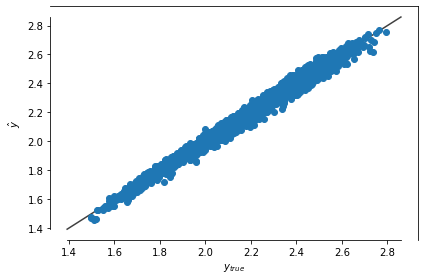

In [58]:
plot_parity(prediction_test[:,0], y_test[:,0])

 /Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning:
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
 /Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning:
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.


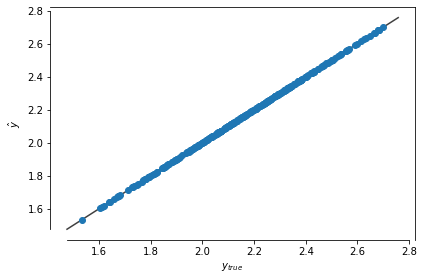

In [59]:
plot_parity(prediction_train[:,0], prediction_train[:,0])

## Get a baseline

### Gibbs

In [60]:
adaboost = GradientBoostingRegressor(n_estimators=500)

adaboost.fit(X_train, y_train[:,1])

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [61]:
prediction_test = adaboost.predict(X_test)
prediction_train = adaboost.predict(X_train)

 /Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning:
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
 /Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning:
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.


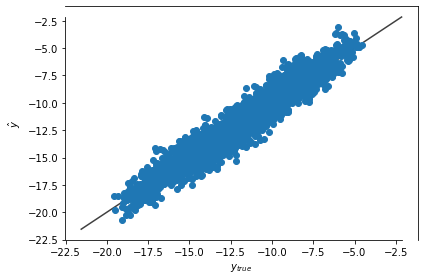

In [62]:
plot_parity(prediction_test, y_test[:,1])

 /Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning:
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
 /Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning:
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.


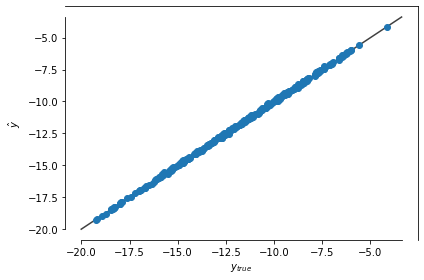

In [63]:
plot_parity(prediction_train, y_train[:,1])

## Virial

In [64]:
adaboost = GradientBoostingRegressor(n_estimators=500)

adaboost.fit(X_train, y_train[:,0])

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [65]:
prediction_test = adaboost.predict(X_test)
prediction_train = adaboost.predict(X_train)

 /Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning:
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
 /Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning:
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.


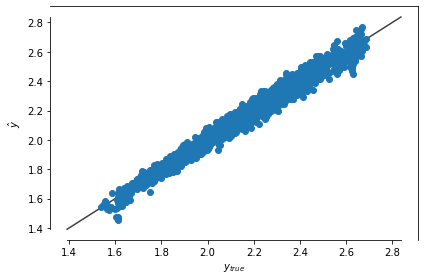

In [66]:
plot_parity(prediction_test, y_test[:,0])

 /Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning:
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
 /Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning:
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.


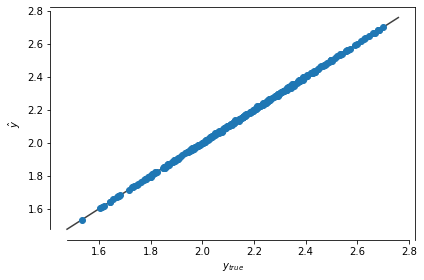

In [67]:
plot_parity(prediction_train, y_train[:,0])

## GP coregionalized

In [22]:
import GPy

In [134]:
K = GPy.kern.Matern32(NFEAT) 
icm = GPy.util.multioutput.ICM(input_dim=NFEAT,num_outputs=2,kernel=K)
m = GPy.models.GPCoregionalizedRegression([X_train, X_train], 
                                                [y_train[:,0].reshape(-1,1), y_train[:,1].reshape(-1,1)], 
                                                kernel=icm)

In [135]:
m.optimize()

In [83]:
import matplotlib as mpl

In [136]:
newX = np.hstack([X_test,0 * np.ones_like(X_test)])
mu_c0, var_c0 =m.predict(newX,Y_metadata={'output_index':0 * np.ones((newX.shape[0],1)).astype(int)})

In [137]:
newX = np.hstack([X_test, 1 * np.ones_like(X_test)])
mu_c1, var_c1 =m.predict(newX,Y_metadata={'output_index': 1 * np.ones((newX.shape[0],1)).astype(int)})

In [138]:
get_metrics(mu_c0, y_test[:,0])

{'r2': 0.9808324547037548,
 'mae': 0.02607533434493928,
 'max_error': 0.12448405765620496}

In [139]:
get_metrics(mu_c1, y_test[:,1])

{'r2': 0.9665125395251177,
 'mae': 0.4782843875712748,
 'max_error': 2.366379255778657}

In [113]:
def plot_parity(y_pred0, y_true0, var0, y_pred1, y_true1, var1, outname=None):
    fig, ax = plt.subplots(1,2)


    # now plot both limits against eachother
    ax[0].scatter(y_true0, y_pred0, c=var0, cmap=plt.cm.coolwarm, s=.3)
    ax[1].scatter(y_true1, y_pred1, c=var1, cmap=plt.cm.coolwarm, s=.3)
    
    for a in ax:
        a.spines['left'].set_smart_bounds(True)
        a.spines['bottom'].set_smart_bounds(True)
        a.set_xlabel(r'$y_{true}$')
        lims = [
            np.min([a.get_xlim(), a.get_ylim()]),  # min of both axes
            np.max([a.get_xlim(), a.get_ylim()]),  # max of both axes
        ]
        a.plot(lims, lims, 'k-', alpha=0.75,  zorder=0)
            
    ax[0].set_ylabel(r'$\hat{y}$')
    fig.tight_layout()
    
    if outname is not None: 
        fig.savefig(outname, bbox_inches='tight')

 /Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning:
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
 /Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning:
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.


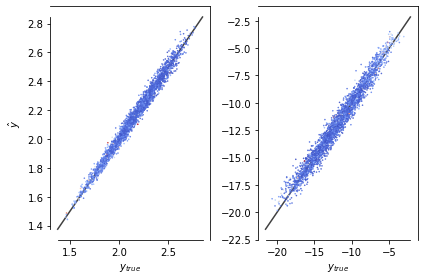

In [115]:
plot_parity(mu, y_test[:,0], var, mu2, y_test[:,1], var1, 'test.pdf')

## Compare against simple GP models

In [133]:
m_0 = GPy.models.GPRegression(X_train, y_train[:,0].reshape(-1,1), 
                                                kernel=K)

In [120]:
m_0.optimize()

In [ ]:
m_1 = GPy.models.GPRegression(X_train, y_train[:,1].reshape(-1,1), 
                                                kernel=K)

In [121]:
m_1.optimize()

In [127]:
mu1, var1 = m_1.predict(X_test)

In [128]:
mu0, var0 = m_0.predict(X_test)

 /Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning:
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
 /Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning:
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.


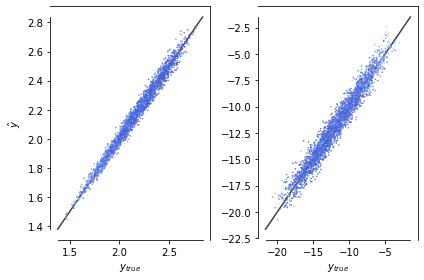

In [129]:
plot_parity(mu0, y_test[:,0], var0, mu1, y_test[:,1], var1, 'test.pdf')

In [146]:
import sys
sys.path.append('..')
from dispersant_screener.utils import get_metrics

In [131]:
get_metrics(mu0, y_test[:,0])

{'r2': 0.9809381191584992,
 'mae': 0.025979655417964324,
 'max_error': 0.1201851222245649}

In [132]:
get_metrics(mu1, y_test[:,1])

{'r2': 0.9526982533077336,
 'mae': 0.5746390319413412,
 'max_error': 3.0826903982358154}

In [145]:
def get_variance_descriptors(var):
    return {
        'max_var': np.max(var),
        'min_var': np.min(var),
        'mean_var': np.mean(var),
        'median_var': np.median(var),
        'std_var': np.std(var)
    }

In [147]:
get_variance_descriptors(var0)

{'max_var': 0.01163112528151011,
 'min_var': 3.9605432596094945e-08,
 'mean_var': 0.0012168587524108174,
 'median_var': 0.0009197160407817776,
 'std_var': 0.0010276994468042789}

In [148]:
get_variance_descriptors(var_c0)

{'max_var': 0.011931927501389161,
 'min_var': 9.999718386666245e-09,
 'mean_var': 0.0011813766385759825,
 'median_var': 0.000882590365300473,
 'std_var': 0.0010298224000639302}

In [149]:
get_variance_descriptors(var1)

{'max_var': 0.01163105582659596,
 'min_var': 9.999733485822127e-09,
 'mean_var': 0.001216832769678883,
 'median_var': 0.0009196906536181882,
 'std_var': 0.0010276949977108393}

In [150]:
get_variance_descriptors(var_c1)

{'max_var': 1.943465577224908,
 'min_var': 0.3457292451966461,
 'mean_var': 0.5072950786414919,
 'median_var': 0.46615119046884473,
 'std_var': 0.14832893129416594}

<bound method GP.to_dict of <GPy.models.gp_coregionalized_regression.GPCoregionalizedRegression object at 0x7fd0bf77cdd8>>